In [1]:
# Import dependencies
import os, sys
from PIL import Image
from IPython.display import display
from IPython.display import Image as _Imgdis
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix  # evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# import keras 


In [2]:
labels = np.array(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'])
X = []
y = []
samples = 15000

for label in labels:
    folder = './Rice_Image_Dataset/' + label + '/'
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for i in range(samples):
        img = Image.open(folder + "/" + files[i])
        img_gray = img.convert('L')
        img_array = np.asarray(img_gray)
        X.append(img_array)
        y.append(label)

X = np.asarray(X)
Xr = X.reshape(5*samples, 62500)
y = np.array(y)

In [3]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(Xr, y, test_size=0.2, random_state=42)

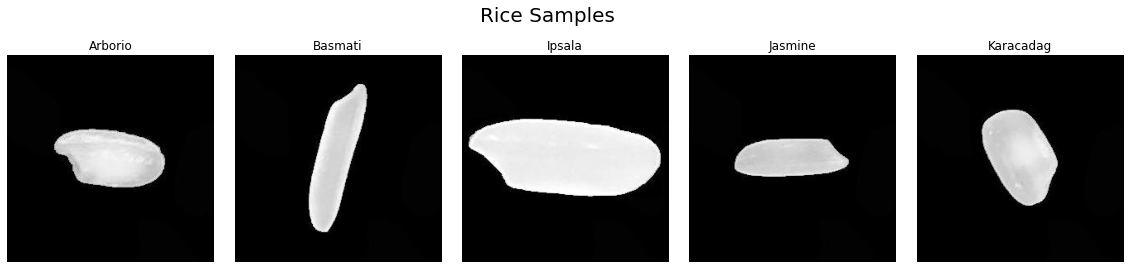

In [4]:
# Show rice
def show_rice(Xr, y, cols=5, title=None):
    fig, axs = plt.subplots(1, cols, figsize=(20,5))
    plt.axis('off')
    for i in range(len(labels)):
        rice = labels[i]
        idx = np.argwhere(y == rice)[0]
        im = Xr[idx].reshape(250, 250)
        axs[i].set_title(f'{rice}')
        axs[i].imshow(im, cmap='gray')
        axs[i].axis('off')
    # change the spacing between the subplots
    plt.subplots_adjust(wspace=0.1, hspace=-0.3)
    if title is not None:
        fig.suptitle(title,fontsize=20)
        fig.subplots_adjust(top=0.99)
    
show_rice(Xr, y, title='Rice Samples')

In [5]:
# # Fit PCA with N = 500
# N = 500
# pca_5 = PCA(n_components=N) # keep all features?
# X_train_reduced = pca_5.fit_transform(X_train)

# # plot the explained variances
# fig, ax1 = plt.subplots(figsize=(12, 5))
# color = 'tab:blue'
# ax1.bar(1+np.arange(N), pca_5.explained_variance_ratio_, color=color)
# ax1.set_xticks(1+np.arange(N, step=50))
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_ylabel("Explained variance ratio", color=color)
# ax1.set_xlabel("Generated feature")

# ax2 = ax1.twinx()
# color = 'tab:red'
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.plot(1+np.arange(N), np.cumsum(pca_5.explained_variance_ratio_), color=color)
# ax2.set_ylabel("Cumulative explained variance ratio", color=color)
# fig.tight_layout()
# plt.show()

In [7]:
# Fit PCA with N = 100
N = 50
pca = PCA(n_components=N) 
X_train_reduced = pca.fit_transform(X_train)

# plot the explained variances
fig, ax1 = plt.subplots(figsize=(12, 5))
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca.explained_variance_ratio_, color=color)
ax1.set_xticks(1+np.arange(N, step=2))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(1+np.arange(N), np.cumsum(pca.explained_variance_ratio_), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)
fig.tight_layout()
plt.show()


MemoryError: Unable to allocate 27.9 GiB for an array with shape (60000, 62500) and data type float64

In [ ]:
N = 20
pca.set_params(n_components=N)
X_train_reduced = pca.fit_transform(X_train)

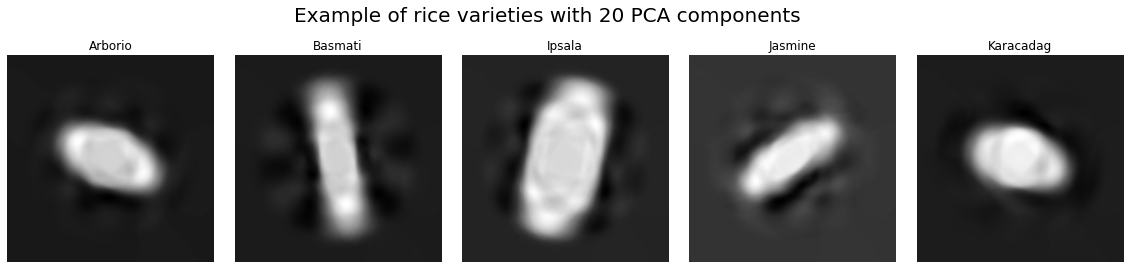

In [ ]:
show_rice(pca.inverse_transform(X_train_reduced), y_train, title=f'Example of rice varieties with {N} PCA components')
plt.show()

In [ ]:
clf_2 = LogisticRegression(solver='sag', max_iter=100) # create the object, SET solver='sag'
clf_2.fit(X_train_reduced, y_train) # fit the data

X_val_reduced = pca.transform(X_val)
y_pred = clf_2.predict(X_val_reduced) # compute the prediction on the validating set
multi_accuracy = accuracy_score(y_val, y_pred) # compute the accuracy score
print(f"Prediction accuracy: {100*multi_accuracy:.2f}%")
# generate_confusion_matrix(y_val, y_pred)
plt.show()

MemoryError: Unable to allocate 27.9 GiB for an array with shape (60000, 62500) and data type float64

In [ ]:
https://www.kaggle.com/code/lgmoneda/from-image-files-to-numpy-arrays
https://www.geeksforgeeks.org/how-to-convert-images-to-numpy-array/
